In [1]:
%matplotlib inline
import os, sys, numpy as np, pandas as pd, tensorflow as tf, re, codecs, json, time
import pickle, collections, random, math, numbers, scipy.sparse as sp, itertools, shutil

def reload(mName):
    import importlib
    if mName in sys.modules:
        del sys.modules[mName]
    return importlib.import_module(mName)

from sklearn.preprocessing import minmax_scale
from scipy.sparse.linalg import svds
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
plt.style.use('ggplot')

utils = reload('utils.utils')
np.set_printoptions(precision=4, suppress=True, linewidth=100)
np.random.seed(42)

<br/>
<br/>
<br/>
## Movielens smallest data set

In [2]:
ratings = pd.read_csv("./data/ml-latest-small/ratings.csv")
movies = pd.read_csv("./data/ml-latest-small/movies.csv")
tags = pd.read_csv("./data/ml-latest-small/tags.csv")

uidEnc, midEnc = LabelEncoder(), LabelEncoder()
uidEnc.fit(ratings.userId)
midEnc.fit(movies.movieId)
# encode user id and movie id to real value
midEnc.fit(movies.movieId)
uidEnc.fit(ratings.userId)

ratings["userId"] = uidEnc.transform(ratings.userId)
ratings["movieId"] = midEnc.transform(ratings.movieId)

movies["movieId"] = midEnc.transform(movies.movieId)

tags["userId"] = uidEnc.transform(tags.userId)
tags["movieId"] = midEnc.transform(tags.movieId)

midMap = pd.Series(dict(zip(movies.movieId, movies.title)))

nUsers, nMovies = len(uidEnc.classes_), len(midEnc.classes_)
print(ratings.shape)
ratings.head()

(100004, 4)


,userId,movieId,rating,timestamp
0,0,30,2.5,1260759144
1,0,833,3.0,1260759179
2,0,859,3.0,1260759182
3,0,906,2.0,1260759185
4,0,931,4.0,1260759205


In [3]:
# movies profile
movies.head()

,movieId,title,genres
0,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,Jumanji (1995),Adventure|Children|Fantasy
2,2,Grumpier Old Men (1995),Comedy|Romance
3,3,Waiting to Exhale (1995),Comedy|Drama|Romance
4,4,Father of the Bride Part II (1995),Comedy


In [4]:
# tags profile
tags.head()

,userId,movieId,tag,timestamp
0,14,304,sandra 'boring' bullock,1138537770
1,14,1517,dentist,1193435061
2,14,5166,Cambodia,1170560997
3,14,6118,Russian,1170626366
4,14,6178,forgettable,1141391765


In [5]:
# 已經產生出檔案的不用跑這一段
# tr, te = utils.split_ratings(ratings, testRatio=0.3)
# tr.to_csv("./data/ml-latest-small/movielens.tr.csv", index=False)
# te.to_csv("./data/ml-latest-small/movielens.te.csv", index=False)
# utils.dumpPickle("./data/ml-latest-small/state.h", 
#         {"uidEnc": uidEnc, "midEnc": midEnc, "midMap": midMap, "nUsers": nUsers, "nMovies":nMovies})

In [6]:
tr = pd.read_csv("./data/ml-latest-small/movielens.tr.csv")
te = pd.read_csv("./data/ml-latest-small/movielens.te.csv")

state = utils.loadPickle("./data/ml-latest-small/state.h")
uidEnc, midEnc, midMap, nUsers, nMovies = \
    (state["uidEnc"], state["midEnc"], state["midMap"], state["nUsers"], state["nMovies"])

# train data rating matrix
trRatingMat = np.zeros((nUsers, nMovies))
# test data rating matrix
teRatingMat = np.zeros((nUsers, nMovies))
for idx, r in tr.iterrows():
    trRatingMat[int(r.userId), int(r.movieId)] = r.rating
for idx, r in te.iterrows():
    teRatingMat[int(r.userId), int(r.movieId)] = r.rating

print("train interaction matrix shape: ", trRatingMat.shape, "test interaction matrix shape: ", teRatingMat.shape)
print("train.shape: ", tr.shape, "test.shape: ", te.shape)
print()
print(tr.head())
print()
print(te.head())

train interaction matrix shape:  (671, 9125) test interaction matrix shape:  (671, 9125)
train.shape:  (69399, 4) test.shape:  (30605, 4)

   userId  movieId  rating   timestamp
0       0      931     4.0  1260759205
1       0     1515     4.0  1260759191
2       0       30     2.5  1260759144
3       0      833     3.0  1260759179
4       0      859     3.0  1260759182

   userId  movieId  rating   timestamp
0       0     1665     4.0  1260759139
1       0     1708     3.0  1260759194
2       0     1743     2.0  1260759198
3       0     1815     2.0  1260759108
4       0     1962     2.5  1260759113


### Data Function
```
1. batch產生資料, 每筆資料有三個欄位 user id, movie id, rating
```

In [7]:
def dataFn(data, n_batch=256, shuffle=False):
    data = data.copy()
    # 讓rating分數只有1 or 0(喜歡 or 不喜歡)
    # data["rating"] = data.rating.map(lambda e: e >= 4).astype(int)
    def _dataFn():
        idx = utils.get_minibatches_idx(len(data), n_batch, shuffle=shuffle)
        for ind in idx:
            rows = data.iloc[ind]
            yield rows.userId.values, rows.movieId.values, rows.rating.values
    return _dataFn

# preview training data
for u, i, r in dataFn(tr, n_batch=10)():
    print("users:\n", u)
    print("items:\n", i)
    print("ratings:\n", r)
    break

users:
 [0 0 0 0 0 0 0 0 0 0]
items:
 [ 931 1515   30  833  859  906 1017 1041 1047 1083]
ratings:
 [ 4.   4.   2.5  3.   3.   2.   2.   2.   2.   3.5]


<br/>
<br/>
<br/>
## Tensorflow Model Based Matrix Factorization

In [8]:
class ModelMF(object):
    def __init__(self, user_num, item_num, dim=5, learning_rate=0.1, reg=0.05, modelDir="./model/model_mf"):
        """初始化 ModelBase Tensorflow Graph."""
        self.user_num = user_num
        self.item_num = item_num
        graph = tf.Graph()
        with graph.as_default():
            with tf.variable_scope("inputs"):
                self.isTrain = tf.placeholder(tf.bool, None)
                # user data
                self.user_batch = tf.placeholder(tf.int32, shape=[None], name="id_user")
                # item data
                self.item_batch = tf.placeholder(tf.int32, shape=[None], name="id_item")
                # labels
                self.rate_batch = tf.placeholder(tf.float32, shape=[None])

            # initFn = tf.contrib.layers.variance_scaling_initializer()
            initFn = tf.contrib.layers.xavier_initializer()
            # Using a global bias term
            self.bias_global = tf.Variable(initFn(shape=[]), name="bias_global")
            with tf.variable_scope("embedding"):
                # User and item bias variables
                self.w_bias_user = tf.Variable(initFn(shape=[user_num]), name="embd_bias_user")
                self.w_bias_item = tf.Variable(initFn(shape=[item_num]), name="embd_bias_item")
                self.w_user = tf.Variable(initFn(shape=[user_num, dim]), name="embd_user")
                self.w_item = tf.Variable(initFn(shape=[item_num, dim]), name="embd_item")
                # ------------------------------------------------------------------------------------------
                # embedding_lookup: Looks up 'ids' in a list of embedding tensors
                # Bias embeddings for user and items, given a batch
                # shape of self.bias_user = (user_batch,)
                # shape of self.bias_item = (item_batch,)
                self.bias_user = tf.nn.embedding_lookup(self.w_bias_user, self.user_batch, name="bias_user")
                self.bias_item = tf.nn.embedding_lookup(self.w_bias_item, self.item_batch, name="bias_item")
                # Weight embeddings for user and items, given a batch
                # shape of self.embd_user = (user_batch * dim)
                # shape of self.embd_item = (item_batch * dim)
                self.embd_user = tf.nn.embedding_lookup(self.w_user, self.user_batch, name="embedding_user")
                self.embd_item = tf.nn.embedding_lookup(self.w_item, self.item_batch, name="embedding_item")

            with tf.variable_scope("computation"):
                # self.embd_user = tf.layers.dropout(self.embd_user, rate=0.5, training=self.isTrain)
                # self.embd_item = tf.layers.dropout(self.embd_item, rate=0.5, training=self.isTrain)
                infer = tf.reduce_sum(tf.multiply(self.embd_user, self.embd_item), 1)
                infer = tf.add(infer, self.bias_global)
                infer = tf.add(infer, self.bias_user)
                self.infer = tf.add(infer, self.bias_item, name="infer")

            with tf.variable_scope("loss"):
                self.regularizer = reg * tf.add(tf.nn.l2_loss(self.embd_user), tf.nn.l2_loss(self.embd_item))
                # l2_loss: Computes half the L2 norm of a tensor without the sqrt => sum(t ** 2) / 2
                # self.loss = tf.nn.l2_loss(self.infer - self.rating[:, tf.newaxis]) + self.regularizer
                self.loss = tf.losses.mean_squared_error(labels=self.infer, predictions=self.rate_batch) + self.regularizer
                
                # self.loss = tf.add(cost_l2, tf.multiply(self.regularizer, penalty))
                # for eval
                self.rmse_loss = tf.sqrt(tf.reduce_mean(tf.losses.mean_squared_error(labels=self.rate_batch, predictions=self.infer)), name="rmse_loss")
                self.mae_loss = tf.reduce_mean(tf.abs(self.infer - self.rate_batch), name="mae_loss")

            with tf.variable_scope("train"):
                self.train_op = tf.train.AdagradOptimizer(learning_rate).minimize(self.loss)

            self.saver = tf.train.Saver(tf.global_variables())
            self.graph = graph
            self.modelDir = modelDir

    def resetModel(self, modelDir):
        """刪除model dir"""
        shutil.rmtree(path=modelDir, ignore_errors=True)
        os.makedirs(modelDir)

    def fit(self, sess, trainGen, testGen, reset=False, nEpoch=50):
        """model training"""
        sess.run(tf.global_variables_initializer())
        if reset:
            print("reset model: clean model dir: {} ...".format(self.modelDir))
            self.resetModel(self.modelDir)
        self.ckpt(sess, self.modelDir)

        start = time.time()
        print("%s\t%s\t%s\t%s" % ("Epoch", "Train Error", "Val Error", "Elapsed Time"))
        minLoss = 1e7
        for ep in range(1, nEpoch + 1):
            tr_loss, tr_total = 0, 0
            for i, (users, items, rates) in enumerate(trainGen(), 1):
                loss, _ = sess.run([self.rmse_loss, self.train_op],
                                      feed_dict={self.user_batch: users,
                                                 self.item_batch: items,
                                                 self.rate_batch: rates,
                                                 self.isTrain: True})
                tr_loss += loss ** 2 * len(users)
                tr_total += len(users)
                print("\rtrain loss: {:.3f}".format(loss), end="")
            if testGen is not None:
                epochLoss = self.epochLoss(sess, testGen)

            tpl = "\r%02d\t%.3f\t\t%.3f\t\t%.3f secs"
            # 紀錄最小valid loss, 若大於之後的loss, 代表model有進步, 才會save model
            if minLoss > epochLoss:
                tpl += ", saving ..."
                self.saver.save(sess, os.path.join(self.modelDir, 'model'), global_step=ep)
                minLoss = epochLoss

            end = time.time()
            print(tpl % (ep, np.sqrt(tr_loss / tr_total), epochLoss, end - start))
            start = end
        return self

    def ckpt(self, sess, modelDir):
        """load latest saved model"""
        latestCkpt = tf.train.latest_checkpoint(modelDir)
        if latestCkpt:
            self.saver.restore(sess, latestCkpt)
        return latestCkpt

    def epochLoss(self, sess, dataGen, tpe="rmse"):
        """return RMSE error from all valid data for eval"""
        totLoss, totCnt = 0, 0
        for users, items, rates in dataGen():
            lossTensor = self.rmse_loss if tpe == "rmse" else self.mae_loss
            loss = sess.run(lossTensor, feed_dict={self.user_batch: users,
                                                   self.item_batch: items,
                                                   self.rate_batch: rates,
                                                   self.isTrain: False})
            totLoss += (loss ** 2 if tpe == "rmse" else loss) * len(users)
            totCnt += len(users)
        return np.sqrt(totLoss / totCnt) if tpe == "rmse" else totLoss / totCnt

    def predict(self, sess, users: list):
        """回傳每個user對於所有item的score"""
        self.ckpt(sess, self.modelDir)
        # ary = np.zeros((len(users), self.item_num))
        predAry = []
        for u in users:
            uBatch = np.repeat(u, self.item_num)
            iBatch = np.arange(self.item_num)
            pred = sess.run(self.infer,
                            feed_dict={self.user_batch: uBatch, self.item_batch: iBatch, self.isTrain: False})
            predAry.append(pred)
        return np.array(predAry)

    def evaluateRMSE(self, sess, dataGen):
        """計算root mean square error"""
        self.ckpt(sess, self.modelDir)
        return self.epochLoss(sess, dataGen, tpe="rmse")

    def evaluateMAE(self, sess, dataGen):
        """計算 mean absolutely error"""
        self.ckpt(sess, self.modelDir)
        return self.epochLoss(sess, dataGen, tpe="mae")

# hyper parameters
learning_rate = 0.1
dim = 16
reg = 0.005
modelDir = "./model/model_mf"

tf.reset_default_graph()
model = ModelMF(user_num=nUsers, item_num=nMovies, learning_rate=0.1, reg=0.005, dim=16, modelDir=modelDir)

## Trainging

In [8]:
n_batch = 128
with tf.Session(graph=model.graph,) as sess:
    model.fit(sess, dataFn(tr, n_batch=n_batch), dataFn(te, n_batch=n_batch), nEpoch=20, reset=True)

reset model: clean model dir: ./model/model_mf ...
Epoch	Train Error	Val Error	Elapsed Time
01	1.412		1.039		3.081 secs, saving ...
02	0.997		1.001		2.515 secs, saving ...
03	0.966		0.984		2.391 secs, saving ...
04	0.945		0.974		2.427 secs, saving ...
05	0.930		0.966		2.408 secs, saving ...
06	0.918		0.959		2.732 secs, saving ...
07	0.909		0.954		2.630 secs, saving ...
08	0.901		0.950		2.454 secs, saving ...
09	0.895		0.946		2.429 secs, saving ...
10	0.889		0.944		2.414 secs, saving ...
11	0.885		0.941		2.494 secs, saving ...
12	0.880		0.939		2.530 secs, saving ...
13	0.877		0.937		2.548 secs, saving ...
14	0.873		0.935		2.429 secs, saving ...
15	0.870		0.934		2.880 secs, saving ...
16	0.868		0.933		2.669 secs, saving ...
17	0.865		0.931		2.481 secs, saving ...
18	0.863		0.930		2.431 secs, saving ...
19	0.861		0.930		2.232 secs, saving ...
20	0.859		0.929		2.783 secs, saving ...


### 單一user rating分布圖

INFO:tensorflow:Restoring parameters from ./model/model_mf\model-20
shape:  (1, 9125) [[ 3.9234  3.4588  3.211  ...,  3.3946  3.3921  3.3891]]


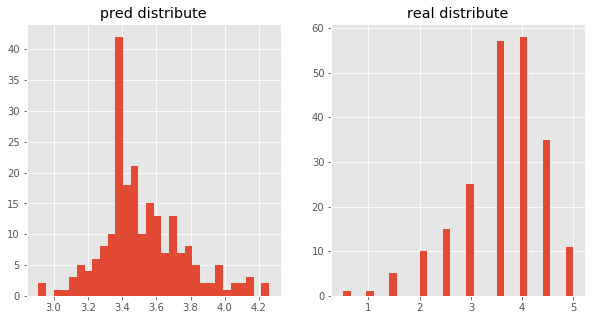

In [9]:
# user id from 0 ~ 670
uid = 22
with tf.Session(graph=model.graph) as sess:
    pred = model.predict(sess, [uid])
print("shape: ", pred.shape, pred)

nnzCoord = teRatingMat[uid].nonzero()
f, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title("pred distribute")
pd.Series(pred.ravel()[nnzCoord]).hist(bins=30, ax=ax[0])
ax[1].set_title("real distribute")
pd.Series(map(lambda e: e, teRatingMat[uid][nnzCoord])).hist(bins=30, ax=ax[1])
plt.show()

<br/>
<br/>
<br/>
## evaluate model

In [7]:
%%time
with tf.Session(graph=model.graph) as sess:
    mae_ = model.evaluateMAE(sess, dataFn(te))
    rmse_ = model.evaluateRMSE(sess, dataFn(te))

print()
print("MAE loss: ", mae_)
print("RMSE loss: ", rmse_)

INFO:tensorflow:Restoring parameters from ./model/model_mf\model-20
INFO:tensorflow:Restoring parameters from ./model/model_mf\model-20

MAE loss:  0.757226303231
RMSE loss:  0.957164534446
Wall time: 506 ms


#### User導向評估(Recall)

In [8]:
# 可給定user id細看每個user的rating與model預測效果
# valid user id from 0 ~ 670
uid = 22
with tf.Session(graph=model.graph) as sess:
    recomm = model.predict(sess, [uid]).ravel()
recommDf = pd.DataFrame(data={
              "userId": uid,
              "movieId": range(len(recomm)),
              "title": midMap[np.arange(len(recomm))].values,
              "rating": teRatingMat[uid, range(len(recomm))],
              "predRating": recomm},
             columns=("userId", "movieId", "title", "rating", "predRating"))
# ascending 可以調整True or False觀察結果
recommDf.query("rating != 0").sort_values("rating", ascending=False)

INFO:tensorflow:Restoring parameters from ./model/model_mf\model-20


,userId,movieId,title,rating,predRating
4417,22,4417,Catch Me If You Can (2002),5.0,3.741811
5623,22,5623,Undertow (2004),5.0,3.392830
4419,22,4419,"Hours, The (2002)",5.0,3.427200
4432,22,4432,City of God (Cidade de Deus) (2002),5.0,3.914758
4371,22,4371,Adaptation (2002),5.0,3.589195
4008,22,4008,And Your Mother Too (Y tu mamá también) (2001),5.0,3.499784
6132,22,6132,Crash (2004),5.0,3.485319
5016,22,5016,Stolen Kisses (Baisers volés) (1968),5.0,3.393593
5761,22,5761,Duel (1971),5.0,3.362864
4875,22,4875,"Unvanquished, The (Aparajito) (1957)",5.0,3.388695


#### Model導向評估(Precision)

In [9]:
print("recommend for user {}".format(uid))
# .query("rating != 0")
recommDf.query("rating != 0").sort_values("predRating", ascending=False)

recommend for user 22


,userId,movieId,title,rating,predRating
5127,22,5127,Eternal Sunshine of the Spotless Mind (2004),4.5,3.922786
4432,22,4432,City of God (Cidade de Deus) (2002),5.0,3.914758
5026,22,5026,"Lord of the Rings: The Return of the King, The...",4.5,3.890644
4231,22,4231,Spirited Away (Sen to Chihiro no kamikakushi) ...,3.5,3.870202
4395,22,4395,"Lord of the Rings: The Two Towers, The (2002)",4.0,3.830681
6383,22,6383,V for Vendetta (2006),4.5,3.780076
4422,22,4422,"Pianist, The (2002)",4.5,3.774691
4411,22,4411,My Neighbor Totoro (Tonari no Totoro) (1988),4.5,3.751936
6294,22,6294,Harry Potter and the Goblet of Fire (2005),3.0,3.750439
3873,22,3873,"Beautiful Mind, A (2001)",4.5,3.748899


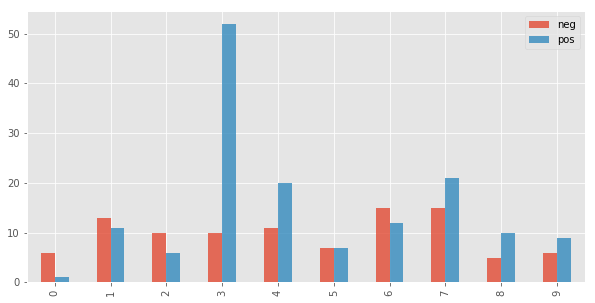

In [10]:
pos_ary, neg_ary = [], []
for label in teRatingMat:
    label = label[label != 0]
    pos_ary.append(sum(label >= 4))
    neg_ary.append(sum(label < 4))
    # print("pos: {}, neg: {}".format(sum(label >= 4), sum(label < 4)))
    
def draw_pos_neg(idx):
    pd.DataFrame(
        index=idx,
        data={"pos": np.array(pos_ary)[idx], "neg": np.array(neg_ary)[idx]}).plot.bar(figsize=(10, 5), alpha=0.8)
    plt.show()

draw_pos_neg(np.arange(len(teRatingMat))[0:10])

### About Test Data Movie Ratings(觀察上圖)
```
1. 0號, 2號, 5號, 9號 user 正向評價數量 < 10, 就算model全部預測命中, 命中率也不會是 100%!
    ex: 0號user只有1個正向評價, 全部命中也指得到0.1的分數
2. 3號user正向評價是負向評價的5倍多, 就算亂猜, 中的機率也很高
```

In [11]:
_ = sum(np.sum(teRatingMat >= 4, 1) < 10)
print("{} 個user正向評價總數小於10!".format(_))

266 個user正向評價總數小於10!


In [12]:
def strict_condition(label):
    label = label[label != 0]
    pos, neg = sum(label >= 4), sum(label < 4)
    return len(label) >= 10 and pos <= neg and pos > 0
    
print("rating數量 >= 10 且 負評價數量 >= 正評價數量 有 [{}] 人".format(sum(strict_condition(label) for label in teRatingMat)))

def norm_condition(label):
    label = label[label != 0]
    return sum(label >= 4) > 0 and sum(label < 4) > 0

print("rating正評價數量 >= 0 且 rating負評價數量 >= 0 有 [{}] 人".format(sum(norm_condition(label) for label in teRatingMat)))

rating數量 >= 10 且 負評價數量 >= 正評價數量 有 [209] 人
rating正評價數量 >= 0 且 rating負評價數量 >= 0 有 [669] 人


#### Precision At K: 
> **預測分數高(rating >= 4)的前10部電影, 和實際user rating比較, 觀察命中率**

In [13]:
%%time
from sklearn.metrics import precision_score

def precision_at_k(truth, pred_mat, condition_fn=None, k=10, label_thres=4):
    hits, total = 0, 0
    for label, pr in zip(truth, pred_mat):
        if not condition_fn(label): continue

        top_k_ind = (pr * (label != 0)).argsort()[::-1][:k]
        hits += sum(label[top_k_ind] >= label_thres)
        total += k
    return hits / total

with tf.Session(graph=model.graph) as sess:
    pred_mat = []
    users = np.arange(nUsers)
    for pos in range(0, nUsers, 200):
        batch = users[pos:pos + 200]
        pred_mat.append(model.predict(sess, batch))
    pred_mat = np.vstack(pred_mat)
    
print( "strict condition precision at 10: ", precision_at_k(teRatingMat, pred_mat, strict_condition, k=10) )
print( "norm condition precision at 10: ", precision_at_k(teRatingMat, pred_mat, norm_condition, k=10) )

INFO:tensorflow:Restoring parameters from ./model/model_mf\model-20
INFO:tensorflow:Restoring parameters from ./model/model_mf\model-20
INFO:tensorflow:Restoring parameters from ./model/model_mf\model-20
INFO:tensorflow:Restoring parameters from ./model/model_mf\model-20
strict condition precision at 10:  0.503349282297
norm condition precision at 10:  0.628998505232
Wall time: 1.26 s


### NDCG: Normalized Discounted Cumulative Gain
1. A measure of ranking quality.
2. loop 每一位user, prediciton score排序後計算NDCG
    <br/>$$ DCG_p = \sum^p_{i = 1} \frac{2^{rel_i} - 1}{log_2(i + 1)} $$<br/>
3. IDCG: Ideal DCG, 為理想狀態下的DCG分數, 即model全部命中的DCG分數, 而NDCG: Normalized DCG, 公式如下
    <br/>$$ NDCG_p = \sum^p_{i = 1} \frac{DCG_p}{IDCG_p} $$<br/>
4. 所以NDCG是一個比值, 介於0 ~ 1之間

In [14]:
def single_user_ndcg(label, score, label_thres=4, k=10):
    """single user ndcg score"""
    nnz = label.nonzero()[0]
    # if np.sum(label >= label_thres) < k: return None
    label, score = label[nnz], score[nnz]
    label = (label >= label_thres).astype(int)
    return utils.ndcg_score(label, score, k)

def all_user_ndcg(label, pred_mat, cond_fn, label_thres=4, k=10):
    """avg of all user ndcg score"""
    tot_ndcg, actual_cnt = 0, 0
    for i, (label, score) in enumerate(zip(teRatingMat, pred_mat)):
        if not cond_fn(label): continue

        ndcg = single_user_ndcg(label, score, k=10)
        if ndcg is not None:
            tot_ndcg += ndcg
            actual_cnt += 1
    return tot_ndcg / actual_cnt

with tf.Session(graph=model.graph) as sess:
    pred_mat = []
    users = np.arange(nUsers)
    for pos in range(0, nUsers, 200):
        batch = users[pos:pos + 200]
        pred_mat.append(model.predict(sess, batch))
    pred_mat = np.vstack(pred_mat)
    
strict_ndcg = all_user_ndcg(teRatingMat, pred_mat, strict_condition, label_thres=4, k=10)
norm_ndcg = all_user_ndcg(teRatingMat, pred_mat, norm_condition, label_thres=4, k=10)
print("strict condition ndcg at 10: ", strict_ndcg)
print("norm condition ndcg at 10: ", norm_ndcg)

INFO:tensorflow:Restoring parameters from ./model/model_mf\model-20
INFO:tensorflow:Restoring parameters from ./model/model_mf\model-20
INFO:tensorflow:Restoring parameters from ./model/model_mf\model-20
INFO:tensorflow:Restoring parameters from ./model/model_mf\model-20
strict condition ndcg at 10:  0.628913505414
norm condition ndcg at 10:  0.754619164278


#### Recall At K: 
> **對於每個user喜歡的前10部電影中(rating >= 4), 和預測值比較, 觀察命中率**

In [15]:
%%time
from sklearn.metrics import recall_score

def recall_at_k(truth, pred_mat, condition_fn, k=10, label_thres=4, pred_thres=0.8):
    hits, total = 0, 0
    for labels, pr in zip(truth, pred_mat):
        if not condition_fn(labels): continue

        top_percentile = np.percentile(pr, pred_thres * 100)
        top_k_ind = labels.argsort()[::-1][:k]
        hits += sum(pr[top_k_ind] >= top_percentile)
        # hits += recall_score(labels >= label_thres, pr >= np.percentile(pr, pred_thres * 100))
        total += k
    return hits / total

with tf.Session(graph=model.graph) as sess:
    pred_mat = []
    users = np.arange(nUsers)
    for pos in range(0, nUsers, 200):
        batch = users[pos:pos + 200]
        pred_mat.append(model.predict(sess, batch))
    pred_mat = np.vstack(pred_mat)
    
def recall_cond_fn(label):
    """recall條件限制為, user在test data正向評價電影至少10部"""
    return sum(label >= 4) >= 10
    
print( recall_at_k(teRatingMat, pred_mat, condition_fn=recall_cond_fn) )

INFO:tensorflow:Restoring parameters from ./model/model_mf\model-20
INFO:tensorflow:Restoring parameters from ./model/model_mf\model-20
INFO:tensorflow:Restoring parameters from ./model/model_mf\model-20
INFO:tensorflow:Restoring parameters from ./model/model_mf\model-20
0.581481481481
Wall time: 14.2 s


#### ROC_CURVE (Receiver operating characteristic), AUC (Area Under Curve)

INFO:tensorflow:Restoring parameters from ./model/model_mf\model-20
auc: 0.746250641782


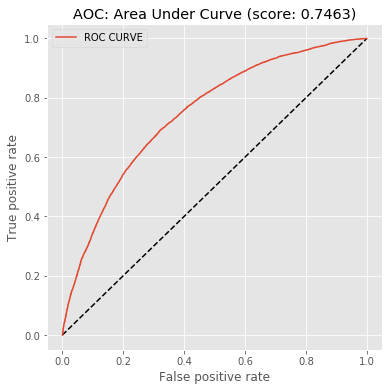

In [9]:
from sklearn.metrics import roc_curve, auc, confusion_matrix

def drawRocCurve(y, predProba):
    fprRf, tprRf, _ = roc_curve(y, predProba, pos_label=1)
    aucScr = auc(fprRf, tprRf)
    print("auc:", aucScr)
    f, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    ax.plot([0, 1], [0, 1], 'k--')
    ax.plot(fprRf, tprRf, label='ROC CURVE')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title('AOC: Area Under Curve (score: {:.4f})'.format(aucScr))
    ax.legend(loc='best')
    plt.show()
    
# 只看非0的部分
coord = teRatingMat.nonzero()
with tf.Session(graph=model.graph) as sess:
    predMat = model.predict(sess, np.arange(teRatingMat.shape[0]).tolist())
    predMat = predMat / predMat.max()
    
# regard rating >= 4 as user like this movie
drawRocCurve((teRatingMat[coord] >= 4).astype(int), predMat[coord])
# ind = predMat[coord].argsort()
# drawRocCurve((teRatingMat[coord] >= 4).astype(int)[ind], predMat[coord][ind[::-1]])

+ Baseline: 不經過訓練隨機產生預測值

auc: 0.503411395633


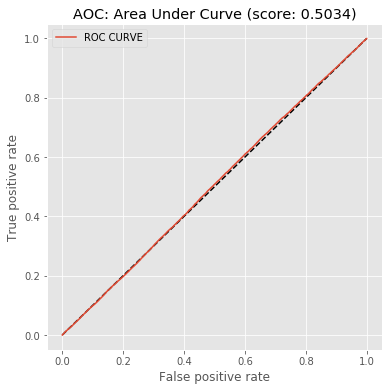

In [17]:
dummyPredMat = np.random.random((nUsers, nMovies))
drawRocCurve((teRatingMat >= 4).astype(int).ravel(), dummyPredMat.ravel())

+ 不經過訓練隨機產生預測值 precision at 10

In [22]:
print( "strict condition precision at 10: ", precision_at_k(teRatingMat, dummyPredMat, strict_condition, k=10) )
print( "norm condition precision at 10: ", precision_at_k(teRatingMat, dummyPredMat, norm_condition, k=10) )

strict condition precision at 10:  0.376555023923
norm condition precision at 10:  0.547085201794


+ 不經過訓練隨機產生預測值 ndcg at 10

In [23]:
strict_ndcg = all_user_ndcg(label, dummyPredMat, strict_condition, label_thres=4, k=10)
norm_ndcg = all_user_ndcg(label, dummyPredMat, norm_condition, label_thres=4, k=10)
print("strict condition ndcg at 10: ", strict_ndcg)
print("norm condition ndcg at 10: ", norm_ndcg)

strict condition ndcg at 10:  0.438605337457
norm condition ndcg at 10:  0.635907004787


<br/>
<br/>
<br/>
## 取出movies embedding, 使用cosine similarity列出最相似的電影

In [18]:
movies[movies.title.str.contains("Toy")]

,movieId,title,genres
0,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1579,1579,Babes in Toyland (1961),Children|Fantasy|Musical
1780,1780,Toys (1992),Comedy|Fantasy
2479,2479,Babes in Toyland (1934),Children|Comedy|Fantasy|Musical
2506,2506,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
3829,3829,"Toy, The (1982)",Comedy
4341,4341,Toy Soldiers (1991),Action|Drama
7556,7556,Toy Story 3 (2010),Adventure|Animation|Children|Comedy|Fantasy|IMAX
8437,8437,Toy Story of Terror (2013),Animation|Children|Comedy


In [19]:
from sklearn.metrics.pairwise import cosine_similarity
def most_like(model, seed_movie, k=10):
    with tf.Session(graph=model.graph) as sess:
        model.ckpt(sess, model.modelDir)
        movie_emb = sess.run(model.embd_item, feed_dict={model.item_batch: movies.movieId.values})
        
    most_like = cosine_similarity(movie_emb[seed_movie][np.newaxis, :], movie_emb).ravel().argsort()[::-1][:k]
    return movies.iloc[most_like]

most_like(model, 0, k=10)

INFO:tensorflow:Restoring parameters from ./model/model_mf\model-20


,movieId,title,genres
0,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4351,4351,Thief (1981),Crime|Drama|Thriller
7512,7512,Steam of Life (Miesten vuoro) (2010),Documentary
5225,5225,Throne of Blood (Kumonosu jô) (1957),Action|Drama|Thriller|War
1471,1471,Henry Fool (1997),Comedy|Drama
6780,6780,"Hunting Party, The (2007)",Action|Adventure|Comedy|Drama|Thriller
8521,8521,Nymphomaniac: Volume II (2013),Drama|Mystery
3787,3787,Clambake (1967),Musical
7031,7031,Sukiyaki Western Django (2008),Action|Western
2848,2848,Where the Heart Is (2000),Comedy|Drama
